# Introduction to NEST

NEST stands for Neural Simulation Tool. It's capabilities are intented for the simulation of point neurons and neurons with few electrical compartments in large networks. With this framework, it's possible to study phenomenological synapse models (STDP, STP) as well as gap junctions, neuromodulation and structural plasticity. It's also capable of simulating many different types of neuron models such as rate models and binary neurons.

It's programmed in C++ with a Python frontend so that simulations can be run easily with a couple of lines of code. Moreover, it supports for hybrid parallelization using OpenMP and MPI libraries.

### Why we use NEST?

Well, each neuron model needs to be assigned an appropiate solver. The solver requires to perform exact integration  and spikes are usually restricted to the computation time scale. Moreover, spike interaction can be performed by event-driven simulation or a continous time simulation for some models.

Besides these reasons, the programmers of NEST maintain the code and its development is driven by scientific needs.

The NEST simulator recreates the electrophysiological experiment in the laboratory. Inside this framework, a neural system has a collection of **Nodes** and **Connections** which are defined by the user's code. **Nodes** represent *neurons* and *devices* whereas **Connections** represent *synapses*.

To measure activity of a neuron or of a neural system, you may connect *devices* to them such as a voltmeter, a spike generator, etc. These instruments are usually present in all electrophysiological experiments! In NEST, the readings of these devices are written on to memory and can be accessed and plotted after the simulation is finished.

PyNEST is a python library that provides the instructions for the python interpreter to interact with the NEST simulator.

In the following tutorial, we will cover the following aspects of the library:

* Creating nodes
* Connecting nodes with default and specific connectivities
* Performing simulations 
* Extracting and plotting measurements

**Documentation: http://nest-simulator.org/documentation**

Before we start, let's import the necessary libraries.

In [1]:
import nest
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 300.0 # modifying dots per inch for figures

Please note that if you need to import other packages like scipy or scikit-learn, you should import these before nest.

**For NEST to simulate different experiments, its kernel (core functionality) needs to be reseted for every new simulation. Please remember to run this code before running each simulation.**

In [3]:
nest.ResetKernel() # reset simulation kernel

### First things first: accesing help

In [4]:
nest.help()

Type 'nest.helpdesk()' to access the online documentation in a browser.
Type 'nest.help(object)' to get help on a NEST object or command.

Type 'nest.Models()' to see a list of available models in NEST.
Type 'nest.authors()' for information about the makers of NEST.
Type 'nest.sysinfo()' to see details on the system configuration.
Type 'nest.version()' for information about the NEST version.

For more information visit https://www.nest-simulator.org.


In [5]:
nest.helpdesk() # opens the html helpbook for NEST commands 

### Creating nodes and connections with default values

Conceptually, neural networks consists of neurons and connections. Nodes can be *neurons*, *sub-networks* or *devices* inside the NEST framework. We will use devices to stimulate neurons and to measure their membrane potential. Sub-networks, on the other hand, are arrangements of neurons whose parameters may be modified as a group. We will look at sub-networks in the following lectures. 

For now, we will focus on constructing a leaky integrate-and-fire (LIF) neuron with delta-shaped synaptic currents:

<img src="https://icwww.epfl.ch/~gerstner/SPNM/img378.gif">

In this figure, a delta-shaped pulse $\delta(t-t_j^f)$ from neuron $j$ is being transmitted along its axon until it reaches neuron $i$'s dendrites through a synapse.

Synapses are modelled as low-pass RC circuit filters which output a current $\alpha(t-t_j^f)$. These presynaptic currents reach the soma as an input current $I(t)$ which charges the capacitor $C$ (integration) while some of it leaks out through the resistance $R$. The electrical components here represent a circuit modelization of the biological mechanisms happening at the synapse and the soma.

In this model, the membrane's potential is represented by capacitor $C$ such that when it has enough charge and reaches the threshold potential $\vartheta$, a spike $\delta(t-t_i^f)$ is generated and transmitted.

In [6]:
# create LIF neuron with alpha-function shaped synaptic currents
neuron=nest.Create('iaf_psc_alpha')

Parameters of this neuron can be accessed with the `GetStatus()` function:

In [7]:
# get the parameter list and values of a node
nest.GetStatus(neuron)

({'archiver_length': 0,
  'beta_Ca': 0.001,
  'C_m': 250.0,
  'Ca': 0.0,
  'E_L': -70.0,
  'element_type': <SLILiteral: neuron>,
  'frozen': False,
  'global_id': 1,
  'I_e': 0.0,
  'local': True,
  'local_id': 1,
  'model': <SLILiteral: iaf_psc_alpha>,
  'node_uses_wfr': False,
  'parent': 0,
  'post_trace': 0.0,
  'recordables': (<SLILiteral: I_syn_ex>,
   <SLILiteral: I_syn_in>,
   <SLILiteral: V_m>,
   <SLILiteral: weighted_spikes_ex>,
   <SLILiteral: weighted_spikes_in>),
  'supports_precise_spikes': False,
  'synaptic_elements': {},
  't_ref': 2.0,
  't_spike': -1.0,
  'tau_Ca': 10000.0,
  'tau_m': 10.0,
  'tau_minus': 20.0,
  'tau_minus_triplet': 110.0,
  'tau_syn_ex': 2.0,
  'tau_syn_in': 2.0,
  'thread': 0,
  'thread_local_id': -1,
  'V_m': -70.0,
  'V_min': -inf,
  'V_reset': -70.0,
  'V_th': -55.0,
  'vp': 0},)

From this list, please note the values of `C_m`, `E_L`, `tau_m`, `V_m`, `V_reset` and `V_th`. The units of each parameter is not represented but are standarized to `pF` (picofaraday), `ms` (miliseconds) and `mV` (milivolts). 

You might have noticed that there is no parameter for the membrane resistance `R_m` as shown in the previous figure. 

**1.- Can you think of an explanation for this?**

In [8]:
# retrieve a particular set of parameters
nest.GetStatus(neuron,['V_reset','V_th'])

((-70.0, -55.0),)

In [9]:
# create a spike generator
spikegenerator=nest.Create('spike_generator')

Parameters of this device can be modified using the `SetStatus()` function:

In [10]:
# modify spike generation to values 10 and 50 ms
nest.SetStatus(spikegenerator,{'spike_times': [10.,50.]})

Devices also have various parameters depending on their usage. For this particular device, we should only worry about the spike and time related parameters.

In [11]:
nest.GetStatus(spikegenerator)

({'allow_offgrid_spikes': False,
  'allow_offgrid_times': False,
  'element_type': <SLILiteral: stimulator>,
  'frozen': False,
  'global_id': 2,
  'local': True,
  'local_id': 2,
  'model': <SLILiteral: spike_generator>,
  'node_uses_wfr': False,
  'origin': 0.0,
  'parent': 0,
  'precise_times': False,
  'shift_now_spikes': False,
  'spike_multiplicities': array([], dtype=int64),
  'spike_times': array([10., 50.]),
  'spike_weights': array([], dtype=float64),
  'start': 0.0,
  'stop': 1.7976931348623157e+308,
  'supports_precise_spikes': False,
  'thread': 0,
  'thread_local_id': -1,
  'vp': 0},)

In [12]:
# create a voltmeter
voltmeter=nest.Create('voltmeter')

Let's connect the spike generator and the voltmeter to the neuron.

In [13]:
# connect spike generator with a given synaptic specification (weight)
nest.Connect(spikegenerator, neuron, syn_spec={'weight':1e3})
# connect voltmeter to the neuron for measurements
nest.Connect(voltmeter, neuron)

These connectivities are not reflected in the node's parameter list but you may use `GetConnections()` function to review them. The return value of this function is a tuple that contains a list in which the first and second values are the global source and target node identifiers (ids) in the simulation. These parameters are shown in the node's parameter list.

In [14]:
# get status of connections of a given node
nest.GetConnections(spikegenerator)

(array('l', [2, 1, 0, 0, 0]),)

**2.- Can you grab the value of the target id from the previous output?**

In [15]:
#nest.GetConnections(spikegenerator)[0][1]

Simulate for 100 ms and observe the results

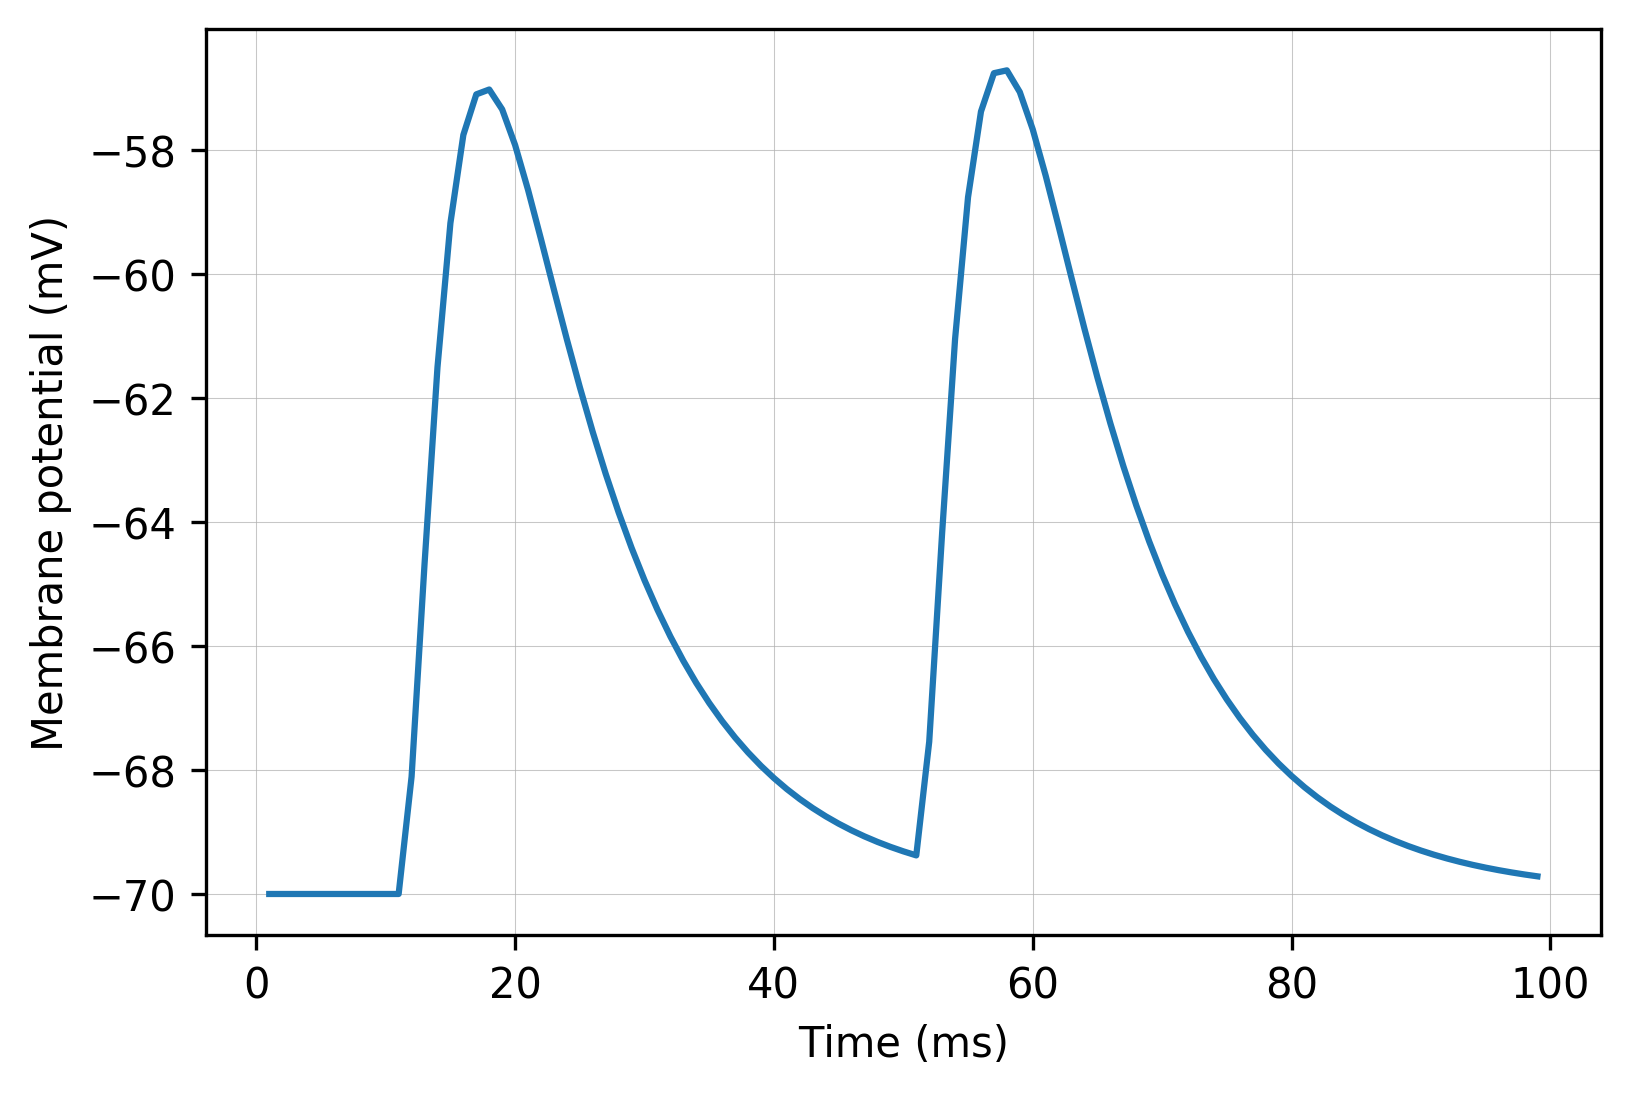

In [16]:
### run simulation for 100ms
nest.Simulate(100.)

# read out recording time and voltage from voltmeter (check the parameter list!)
times=nest.GetStatus(voltmeter)[0]['events']['times']
voltage=nest.GetStatus(voltmeter)[0]['events']['V_m']

# plot results
plt.plot(times,voltage)
plt.xlabel('Time (ms)');
plt.ylabel('Membrane potential (mV)')
plt.grid(linestyle='-', linewidth=.25, alpha=.7)
plt.show()

**3.- What can we observe here? Are these neuron spikes?** What happens if we modify the external current `I_e` or the threshold voltage `V_th` of the neuron model? How about modifying the synaptic connection between the spike generator and the neuron?

In [17]:
#nest.SetStatus(neuron,{'V_th': -58.0}) # modifying the threshold

In [18]:
#nest.SetStatus(neuron,{'I_e': 300.0}) # modifying external current to LIF neuron to 300 pA

In this neuron model, the membrane potential does not follow the biologically observed dynamics that neurons have. Their use is limited to understand and experiment with network dynamics and spiking activity. 

For comparison, let's observe the membrane potential of a **Hodgkin-Huxley neuron model**.

<img src="https://www.researchgate.net/profile/Surachoke_Thanapitak/publication/303389501/figure/fig3/AS:364108500226050@1463821639890/Fig23-illustrates-the-components-of-the-Hodgkin-Huxley-model-The-capacitance-C-m-is.png" width=450 height=450>

The HH-model (Hodgkin and Huxley, 1952) considers the *ionic channels* present on the cellular membrane. These channels allows the conduction of specific types of ions. Sodium channels (Na+) are scarce inside the cell, so that when sodium channel opens, positive charges rush into the cell to cause excitation. Potassium ions (K+) are rich inside the cell, so that when potassium channel opens, positive charges rush out of the cell to cause inhibition. The model assumes a *leak* current composed of all other remaining ionic currents (Cl, Mg, etc.)

This model is based on careful data analysis and follows the following equation:

$$C \frac{dV}{dt} = g_{Na}m^3h(E_{Na}-V) + g_Kn^4(E_K-V) + g_L(E_L-V) + I$$

All these parameters can be seen and modified within the NEST framework for that particular neuron model!

In [19]:
nest.ResetKernel() # reset simulation kernel

In [20]:
# create Hodgkin-Huxley neuron with delta-shaped synaptic currents.
neuron=nest.Create('hh_psc_alpha')

In [21]:
# get the parameter list and values of a node
nest.GetStatus(neuron)

({'Act_h': 0.5961207535084603,
  'Act_m': 0.05293248525724958,
  'archiver_length': 0,
  'beta_Ca': 0.001,
  'C_m': 100.0,
  'Ca': 0.0,
  'E_K': -77.0,
  'E_L': -54.402,
  'E_Na': 50.0,
  'element_type': <SLILiteral: neuron>,
  'frozen': False,
  'g_K': 3600.0,
  'g_L': 30.0,
  'g_Na': 12000.0,
  'global_id': 1,
  'I_e': 0.0,
  'Inact_n': 0.3176769140606974,
  'local': True,
  'local_id': 1,
  'model': <SLILiteral: hh_psc_alpha>,
  'node_uses_wfr': False,
  'parent': 0,
  'post_trace': 0.0,
  'recordables': (<SLILiteral: Act_h>,
   <SLILiteral: Act_m>,
   <SLILiteral: I_syn_ex>,
   <SLILiteral: I_syn_in>,
   <SLILiteral: Inact_n>,
   <SLILiteral: V_m>),
  'supports_precise_spikes': False,
  'synaptic_elements': {},
  't_ref': 2.0,
  't_spike': -1.0,
  'tau_Ca': 10000.0,
  'tau_minus': 20.0,
  'tau_minus_triplet': 110.0,
  'tau_syn_ex': 0.2,
  'tau_syn_in': 2.0,
  'thread': 0,
  'thread_local_id': -1,
  'V_m': -65.0,
  'vp': 0},)

As with the LIF neuron model, these parameters are expressed in standard units such as `mV` (milivolts), `pF` (picofaraday), `ms` (miliseconds),`nS` (nanosiemens, unit of conductance) and `pA` (picoamper). We will use the default values for them.

In [22]:
# create a spike generator
spikegenerator=nest.Create('spike_generator')

In [23]:
# modify spike generation with times 10 and 50 ms
nest.SetStatus(spikegenerator,{'spike_times': [10.,50.]})

In [24]:
# create a voltmeter
voltmeter=nest.Create('voltmeter')

In [25]:
# create add a spikedetector!
spikedetector = nest.Create('spike_detector')

In [26]:
# connect spike generator with a given synaptic specification (weight)
nest.Connect(spikegenerator, neuron, syn_spec={'weight':1e3})
# connect voltmeter to the neuron for measurements
nest.Connect(voltmeter, neuron)
# connect spikedetector to the neuron
nest.Connect(neuron, spikedetector)

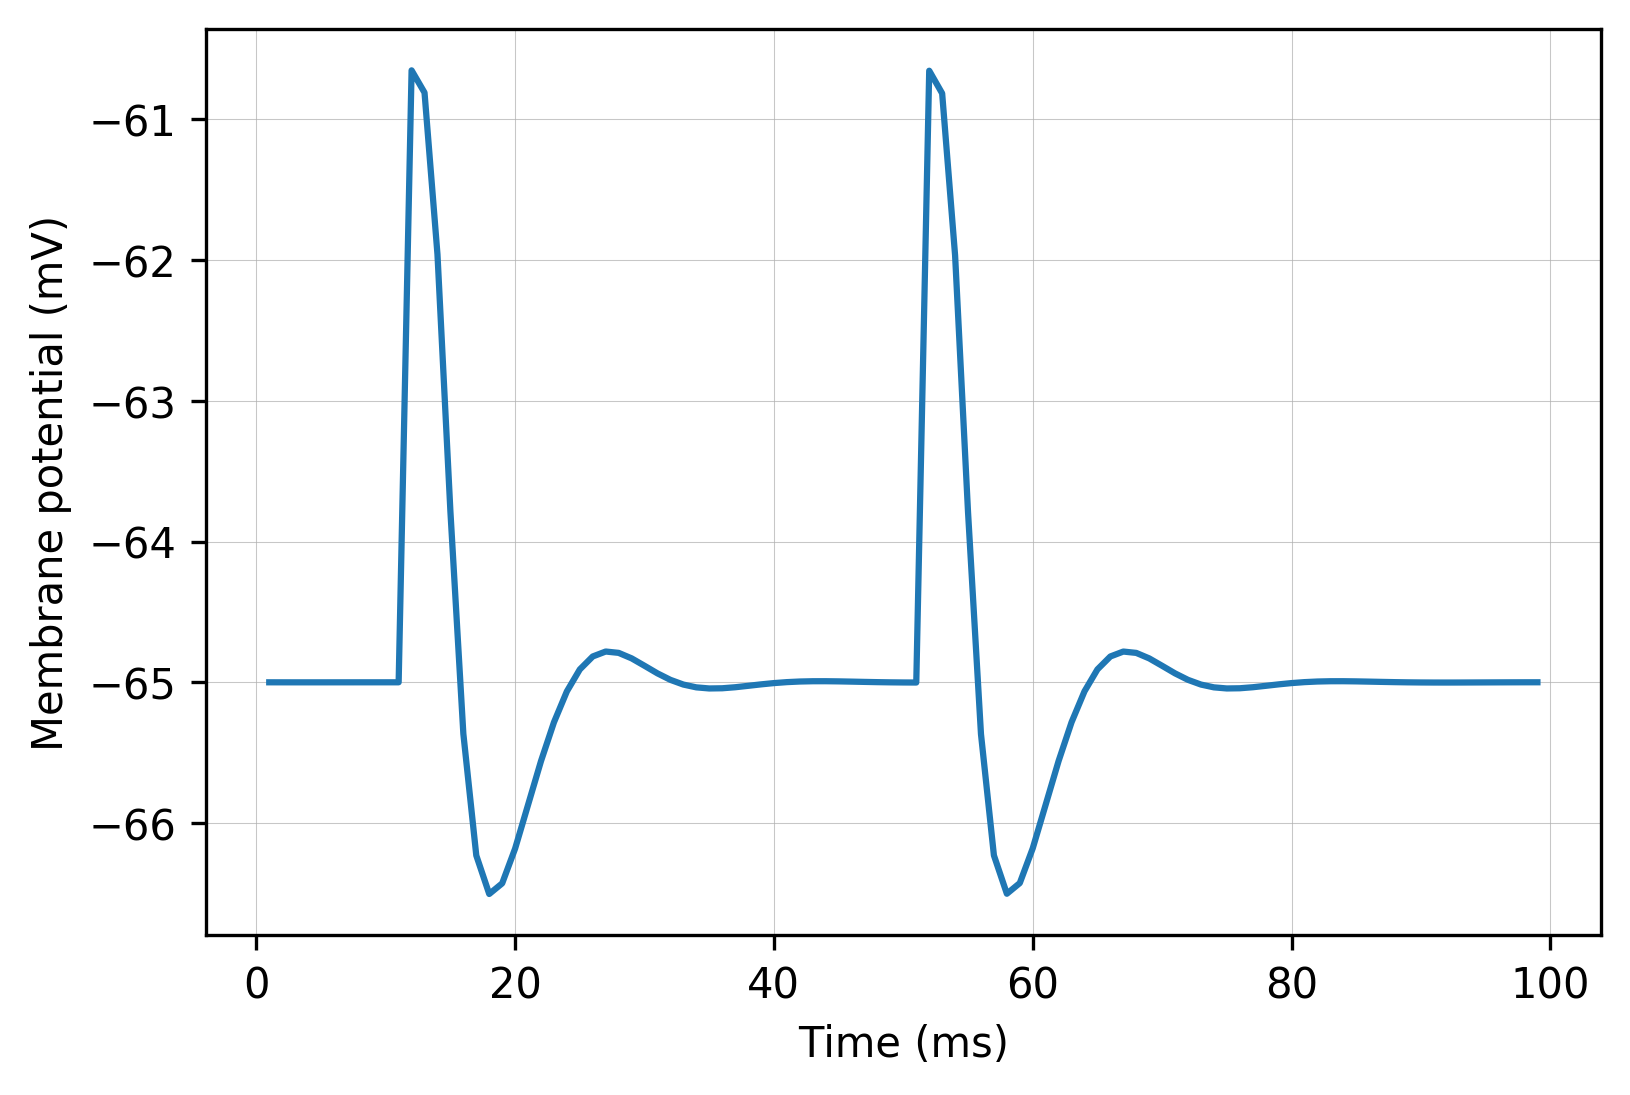

In [27]:
### run simulation for 100ms
nest.Simulate(100.)

# read out recording time and voltage from voltmeter (check the parameter list!)
times=nest.GetStatus(voltmeter)[0]['events']['times']
voltage=nest.GetStatus(voltmeter)[0]['events']['V_m']

# plot results
plt.plot(times,voltage)
plt.xlabel('Time (ms)');
plt.ylabel('Membrane potential (mV)')
plt.grid(linestyle='-', linewidth=.25, alpha=.7)
plt.show()

**4.- Modify the previous example to observe spikes.** Then run the following cell to check if there were any spikes:

In [28]:
spikes=nest.GetStatus(spikedetector, "n_events")[0]
print("Number of spikes: {0}".format(spikes))

Number of spikes: 0


Could you observe the spikes? Just after a spike, the membrane potential resets to -77 mV and a short refractory period of 2 ms (check these parameter values from the parameter list shown above!). During this period, the neuron is unable to react to excitation.

**5.- Can you try exciting the neuron during this period to observe this phenomena?**

### Connecting nodes with different inputs

In [29]:
nest.ResetKernel() # reset simulation kernel

To compare neurons with different inputs, let's see how the parameters of the input affect the neurons' output. In the following example, we will use constant input current and a Poisson spike train with the same mean strength as the constant input current. The probability density function and firing rates of neurons will be shaped given by these inputs. 

First, let us define the parameters of the simulation and input currents.

In [30]:
# simulation time
T = 1.2e3 # (ms)
# firing rate of external Poisson source
nu_ext = 15e3 # (Hz)
# synaptic weight
J = 0.08 # (mV)
# delay
d = 0.1 # (ms)
# membrane potential capacitance
C = 250.0 # (pF)
# mean input in pAa
mu = J*1e-3*nu_ext*C
# external current
I_ext = mu

We will create a dictionary for neuron parameters:

In [31]:
# neuron parameter
neuron_params = {
    'C_m': C, # (pF)
    'E_L': 0., # (mV)
    'I_e': 0.0, # (pA)
    'V_m': 0., # (mV)
    'V_reset': 0., # (mV)
    'V_th': 15., # (mV)
    't_ref': 2.0, # (ms)
    'tau_m': 10.0, # (ms)
}

We can use this to pass as an argument of the `SetDefaults()` function. Whenever we create neurons after calling this function, the default parameter values will be those which we have defined previously.

Let's use a LIF neuron model with delta-function synaptic currents

In [32]:
# set default neuron parameters
nest.SetDefaults('iaf_psc_delta', neuron_params)

In [33]:
# create two 'iaf_psc_delta' neurons
neurons = nest.Create('iaf_psc_delta', 2)

Neuron id **0** will receieve constant current *I_ext* defined previously.

In [34]:
# supply the first neuron with the constant current I_ext
nest.SetStatus([neurons[0]], {'I_e': I_ext})

Next, we create a poisson spike train using `poisson_generator` as device name. The parameter `rate` will be *nu_ext* defined previously. 

In [35]:
# create Poisson generator with rate nu_ext
poisson_generator = nest.Create('poisson_generator', params={'rate': nu_ext})

In the following code we are creating the necessary devices for measuring the neurons' membrane potential and for detecting any spikes generated by them.

In [36]:
# create two multimeter to record membrane potential of the neurons
multimeters = nest.Create('multimeter', 2)
# set the multimeters to record membrane potentials
nest.SetStatus(multimeters, {'record_from': ['V_m']})
# create two spike detectors to record spikes of neurons
spikedetectors = nest.Create('spike_detector', 2)
# set the spike detectors to record spike times and neuron identifiers, but not to record from file
nest.SetStatus(spikedetectors, [{'withtime': True,'withgid': True,'to_file': False}])

Let us connect the devices to the neurons:

In [37]:
# connect devices to neurons
nest.Connect(poisson_generator, [neurons[1]], syn_spec={'weight':J, 'delay':d})
nest.Connect(multimeters, neurons, 'one_to_one')
nest.Connect(neurons, spikedetectors, 'one_to_one')

In the previous piece of code, we specifically defined connections on a `one_to_one` fashion. This is needed because of the amount of possible connections that we have. Since we generated two of each node, we need to tell *NEST* that we just want this type of connection. Please review other type of connection specifications here:
https://nest-simulator.org/connection_management/.

Next, we will simulate this setup. We will need to save the measurements in lists for later plotting. Try to think by yourself what the parameters in this section mean.

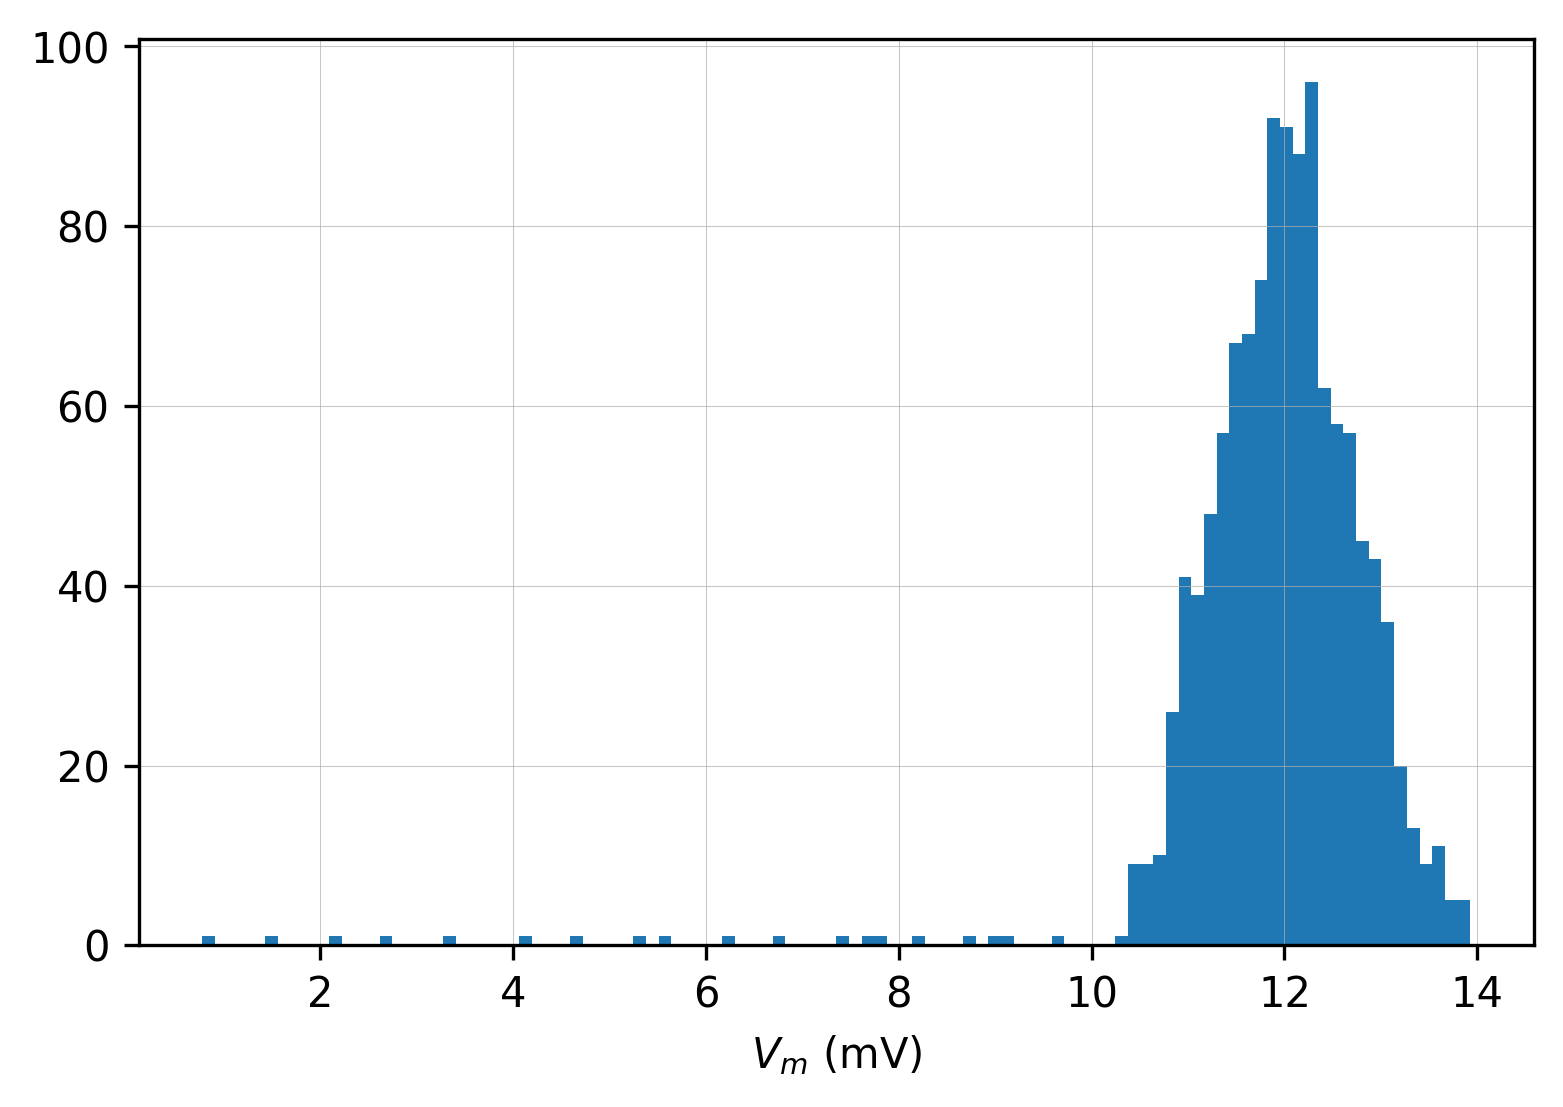

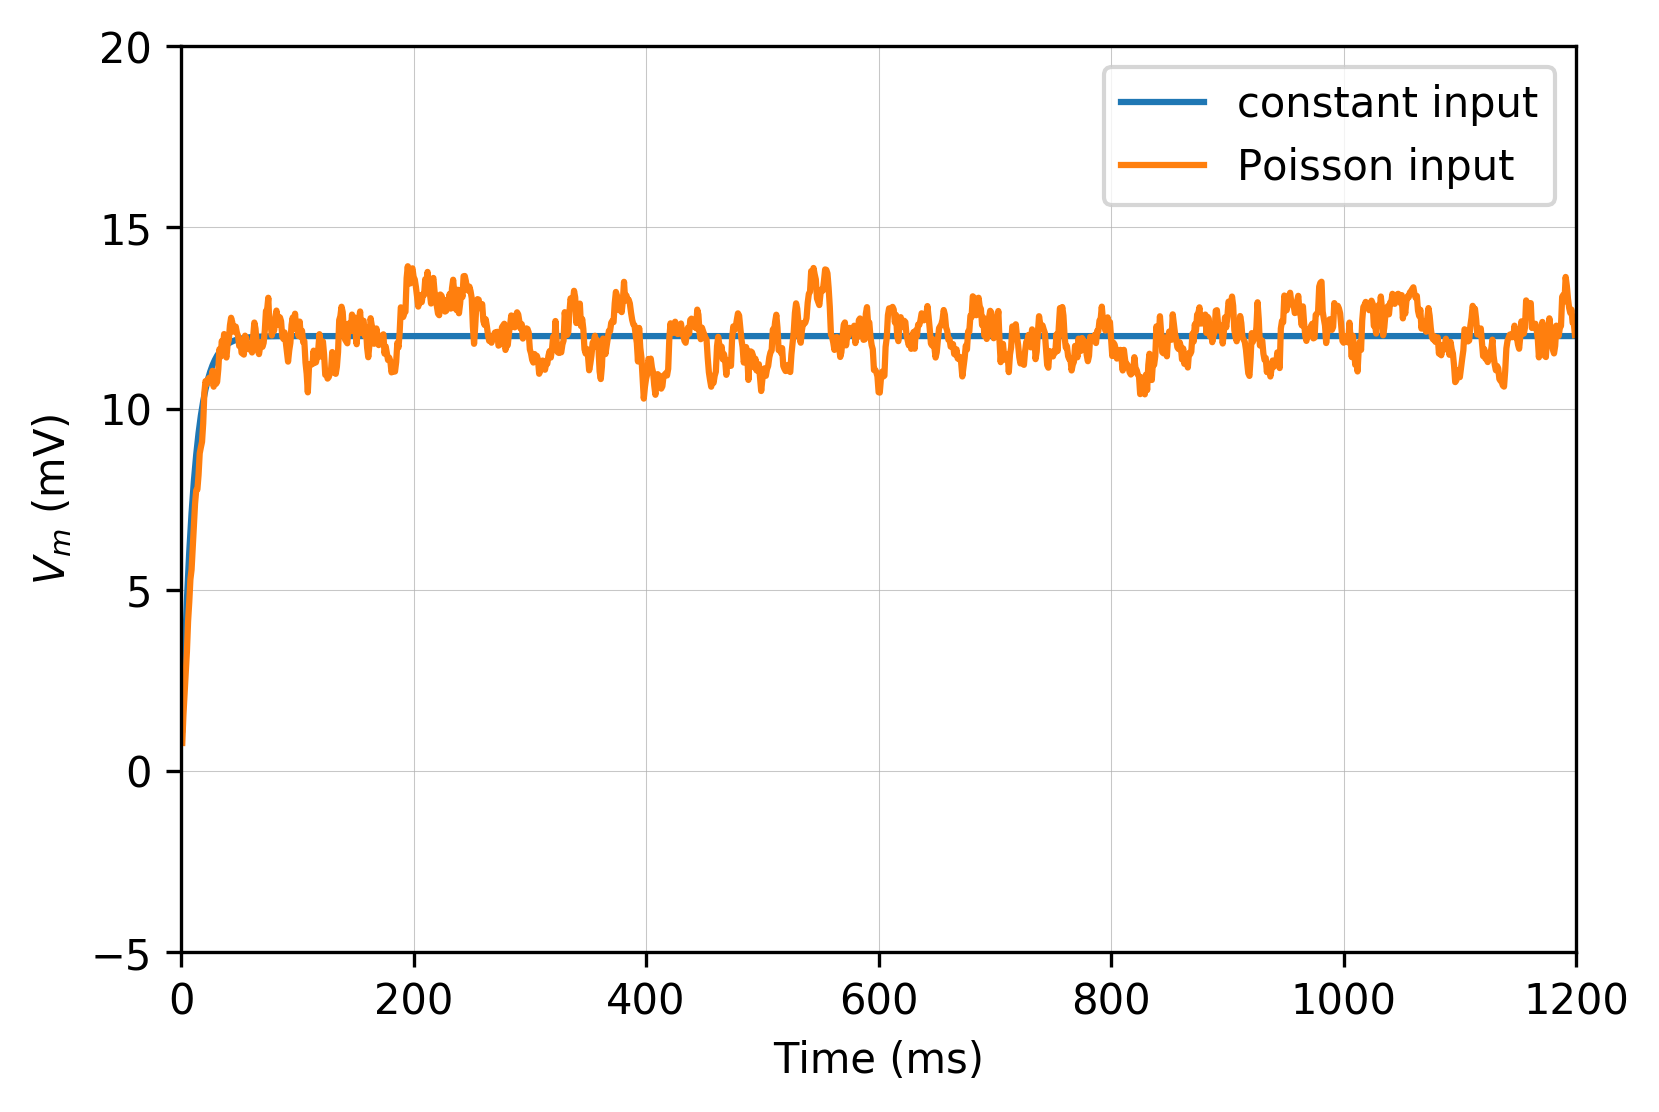

In [38]:
# simulate
nest.Simulate(T)

# readout lists. we will store data in these data structures.
V_mem = []
times = []
spikes = []
for i in range(2):
    data = nest.GetStatus([multimeters[i]])[0]['events']
    V_mem.append(data['V_m'])
    times.append(data['times'])
    spikes.append(nest.GetStatus([spikedetectors[i]])[0]['events']['times'])

# plot histogram of membrane potentials of noise driven neuron
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.hist(V_mem[1], 100)
plt.xlabel(r'$V_m$ (mV)')
plt.grid(linestyle='-', linewidth=.25, alpha=.7)

# plot traces of membrane potential
fig2 = plt.figure(2)
plt.plot(times[0], V_mem[0], label='constant input')
plt.plot(times[1], V_mem[1], label='Poisson input')
plt.xlabel('Time (ms)')
plt.ylabel(r'$V_m$ (mV)')
plt.xlim([0., T])
plt.ylim([-5., 20.])
plt.legend()
plt.grid(linestyle='-', linewidth=.25, alpha=.7)
plt.show()

Measure neurons' firing rate with the following code:

In [39]:
# calculate and print firing rate of neurons
rate = float(len(spikes[0]))/T*1e3
print('Rate of neuron stimulated with constant input: ', rate)
rate = float(len(spikes[1]))/T*1e3
print('Rate of neuron stimulated with Poisson input: ', rate)

Rate of neuron stimulated with constant input:  0.0
Rate of neuron stimulated with Poisson input:  0.0


What!? There are no spikes?! Well, look at the figures and consider the threshold potential value `V_th`. Let's try increasing the synaptic strengh `J`. The neuron receiving Poisson input will be in different firing rate regimes!

**6.- Try to make the neuron fire at an irregular regime.** (J=0.09)
 
**7.- Try to make the neuron spike at a regular regime.**  (J=0.11)

Since we are using the LIF neuron model you will not be able to see *proper* spikes. Instead, you will only see the after-spike dynamics (membrane potential reset and refractory period).

**8.- Repeat the simulations with the HH neuron model**

## Well done!